We will start by importing all necessary libraries

In [150]:
import requests
import os
import json
import pandas as pd
FOURSQUARE_API_KEY = os.environ.get("FOURSQUARE_API_KEY")
YELP_API_KEY = os.environ.get("YELP_API_KEY")
import matplotlib.pyplot as plt
import seaborn as sns

We will also import city_bikes.ipynb here to work with station's location information

In [124]:
import import_ipynb
import city_bikes

In [157]:
# df_bike.head()
# df_bike.shape
# We can check if city_bikes is correctly imported by checking df_bike dataframe


# Foursquare

### Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [127]:
# We check documentation to find Foursquare endpoint for searching places
foursquare_url = 'https://api.foursquare.com/v3/places/search'
fs_headers = {
    "Accept": "application/json",
    "Authorization": FOURSQUARE_API_KEY
}

def foursquare_places(latitude, longitude, query, radius=1000):
    params = {
        "query": query,
        "ll": f"{latitude},{longitude}",
        "radius": radius,
        "limit": 10
    }
    
    response = requests.get(foursquare_url, headers=fs_headers, params=params)
    return response.json()

In [128]:
# Using Lat Long of Toronto we can see the bike stations and nearby restaurants
fs_latitude = 43.6532
fs_longitude = -79.3832
fs_restaurants = foursquare_places(fs_latitude, fs_longitude, "restaurant")

fs_results = fs_restaurants.get('results', []) 
fs_restaurants_df = pd.DataFrame(fs_results) 
fs_restaurants_df.head() 

,fsq_id,categories,chains,closed_bucket,distance,geocodes,link,location,name,related_places,timezone
0,537773d1498e74a75bb75c1e,"[{'id': 13028, 'name': 'Breakfast Spot', 'shor...",[],VeryLikelyOpen,98,"{'main': {'latitude': 43.653268, 'longitude': ...",/v3/places/537773d1498e74a75bb75c1e,"{'address': '483 Bay St', 'country': 'CA', 'cr...",Eggspectation Bell Trinity Square,{'parent': {'fsq_id': '4ae5df5af964a520c4a221e...,America/Toronto
1,4d306dd82748b60c62b6dba0,"[{'id': 13065, 'name': 'Restaurant', 'short_na...",[],VeryLikelyOpen,216,"{'main': {'latitude': 43.654458, 'longitude': ...",/v3/places/4d306dd82748b60c62b6dba0,"{'address': '220 Yonge St', 'address_extended'...",Trattoria Mercatto,{'parent': {'fsq_id': '4ad77a12f964a520260b21e...,America/Toronto
2,4ad4c060f964a5207cf720e3,"[{'id': 13338, 'name': 'Seafood Restaurant', '...",[],LikelyOpen,312,"{'main': {'latitude': 43.650598, 'longitude': ...",/v3/places/4ad4c060f964a5207cf720e3,"{'address': '56 Temperance St', 'country': 'CA...",John & Sons Oyster House,{},America/Toronto
3,57d0a3fb498e0fb29e892eed,"[{'id': 13343, 'name': 'South American Restaur...",[],LikelyOpen,298,"{'main': {'latitude': 43.651907, 'longitude': ...",/v3/places/57d0a3fb498e0fb29e892eed,"{'address': '176 Yonge St', 'country': 'CA', '...",Leña Restaurante,{},America/Toronto
4,5d782433f6e3190008b1a914,"[{'id': 13263, 'name': 'Japanese Restaurant', ...",[],VeryLikelyOpen,303,"{'main': {'latitude': 43.655187, 'longitude': ...",/v3/places/5d782433f6e3190008b1a914,"{'address': '157 Dundas St W', 'country': 'CA'...",Gyubee Japanese Grill,{},America/Toronto


In [158]:
# We can check all the columns and their data type
fs_restaurants_df.dtypes

fsq_id            object
categories        object
chains            object
closed_bucket     object
distance           int64
geocodes          object
link              object
location          object
name              object
related_places    object
timezone          object
dtype: object

### Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

For our Point of Interest we will select restaurants, bars and banks. Looks like there are no rating provided with foresquare places.

In [130]:
# Starting with an empty list
fs_poi_data = []

#Selecting first 5 stations from the df_bike 

fs_selected_stations = df_bike.head(5)

# Iterate through each bike station in df_bike dataframe from city_bikes
for index, row in fs_selected_stations.iterrows():
    latitude = row['latitude'] 
    longitude = row['longitude']
    station_name = row['station_name']
    
    # Query for restaurants, bars, and banks as I think banks could be important as well
    for query in ["restaurant", "bar", "bank"]:
        pois = foursquare_places(latitude, longitude, query, radius=50)
        
        if pois and 'results' in pois:
            for place in pois['results']:
                distance = place.get('distance', None)
                poi_info = {
                    'station_name': station_name,
                    'name': place.get('name', ''),
                    'latitude': latitude,
                    'longitude': longitude,
                    'category': query,
                    'distance': distance 
                }
                fs_poi_data.append(poi_info)  # Add to the empty list

### Put your parsed results into a DataFrame

In [131]:
# Create a df from the data
fs_pois_df = pd.DataFrame(fs_poi_data)

# Check the first few rows of the new df
fs_pois_df.head()

,station_name,name,latitude,longitude,category,distance
0,Summerhill Ave / Maclennan Ave,Dolce Bakery,43.685924,-79.376304,restaurant,38
1,Summerhill Ave / Maclennan Ave,Ashbury Cleaners,43.685924,-79.376304,bar,24
2,Summerhill Ave / Maclennan Ave,Rosedale's Finest,43.685924,-79.376304,bar,27
3,Summerhill Ave / Maclennan Ave,Rosedale 1 Hour Cleaners,43.685924,-79.376304,bar,39
4,Summerhill Ave / Maclennan Ave,Dolce Bakery,43.685924,-79.376304,bar,38


# Yelp

### Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [132]:
# Yelp endpoint for searching places
yelp_url = 'https://api.yelp.com/v3/businesses/search'
y_headers = {
    "Authorization": f"Bearer {YELP_API_KEY}",  
}

def yelp_places(latitude, longitude, query, radius=1000):
    params = {
        "term": query, 
        "latitude": latitude,
        "longitude": longitude,
        "radius": radius,
        "limit": 10  
    }
    
    response = requests.get(yelp_url, headers=y_headers, params=params)
    return response.json() 


In [133]:
# Using Lat Long of Toronto
y_latitude = 43.6532
y_longitude = -79.3832


y_restaurants = yelp_places(y_latitude, y_longitude, "restaurant")
y_results = y_restaurants.get('businesses', [])


y_restaurants_df = pd.DataFrame(y_results)
y_restaurants_df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,location,phone,display_phone,distance,business_hours,attributes,price
0,lwYtNxviXQMP0k8ucLfaWQ,edna-vita-toronto,Edna + Vita,https://s3-media1.fl.yelpcdn.com/bphoto/ot2yoQ...,False,https://www.yelp.com/biz/edna-vita-toronto?adj...,16,"[{'alias': 'wine_bars', 'title': 'Wine Bars'},...",4.4,"{'latitude': 43.64940455, 'longitude': -79.382...",[],"{'address1': '77 Adelaide St W', 'address2': '...",+14375626099,+1 437-562-6099,428.336205,[],"{'business_temp_closed': None, 'menu_url': Non...",NaN
1,r_BrIgzYcwo1NAuG9dLbpg,pai-northern-thai-kitchen-toronto-5,Pai Northern Thai Kitchen,https://s3-media4.fl.yelpcdn.com/bphoto/uAnTcm...,False,https://www.yelp.com/biz/pai-northern-thai-kit...,3740,"[{'alias': 'thai', 'title': 'Thai'}]",4.4,"{'latitude': 43.64784, 'longitude': -79.38872}",[],"{'address1': '18 Duncan Street', 'address2': '...",+14169014724,+1 416-901-4724,739.273351,"[{'open': [{'is_overnight': False, 'start': '1...","{'business_temp_closed': None, 'menu_url': Non...",$$
2,qekAZVcOoJjMBnN5rJ_4fQ,the-rabbit-hole-toronto,The Rabbit Hole,https://s3-media3.fl.yelpcdn.com/bphoto/WX1mq-...,False,https://www.yelp.com/biz/the-rabbit-hole-toron...,46,"[{'alias': 'gastropubs', 'title': 'Gastropubs'}]",4.2,"{'latitude': 43.64995, 'longitude': -79.37976}",[],"{'address1': '21 Adelaide Street W', 'address2...",+16474806963,+1 647-480-6963,451.023940,"[{'open': [{'is_overnight': False, 'start': '1...","{'business_temp_closed': None, 'menu_url': 'ht...",NaN
3,vM_s5ORV4iYTXULxf9Thxw,oeb-breakfast-toronto-street-toronto,OEB Breakfast - Toronto Street,https://s3-media3.fl.yelpcdn.com/bphoto/urEfDa...,False,https://www.yelp.com/biz/oeb-breakfast-toronto...,58,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.4,"{'latitude': 43.650258, 'longitude': -79.376691}",[restaurant_reservation],"{'address1': '20 Toronto Street', 'address2': ...",+14378808291,+1 437-880-8291,619.317635,"[{'open': [{'is_overnight': False, 'start': '0...","{'business_temp_closed': None, 'menu_url': 'ht...",NaN
4,mZRKH9ngRY92bI_irrHq6w,richmond-station-toronto,Richmond Station,https://s3-media3.fl.yelpcdn.com/bphoto/agCQCt...,False,https://www.yelp.com/biz/richmond-station-toro...,948,"[{'alias': 'newcanadian', 'title': 'Canadian (...",4.4,"{'latitude': 43.6513729, 'longitude': -79.379285}",[],"{'address1': '1 Richmond Street W', 'address2'...",+16477481444,+1 647-748-1444,374.815589,"[{'open': [{'is_overnight': False, 'start': '1...","{'business_temp_closed': None, 'menu_url': 'ht...",$$$


In [134]:
y_restaurants_df.dtypes

id                 object
alias              object
name               object
image_url          object
is_closed            bool
url                object
review_count        int64
categories         object
rating            float64
coordinates        object
transactions       object
location           object
phone              object
display_phone      object
distance          float64
business_hours     object
attributes         object
price              object
dtype: object

We get Rating and Review Count with YELP API, along with many more information, which we didn't get with FOURSQUARE API.

### Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [135]:
# Starting with an empty list
yelp_poi_data = []

# Selecting first 5 stations from the df_bike
yelp_selected_stations = df_bike.head(5)

# Iterate through each bike station in df_bike dataframe from city_bikes
for index, row in yelp_selected_stations.iterrows():
    latitude = row['latitude'] 
    longitude = row['longitude']
    station_name = row['station_name']
    
    # Query for restaurants, bars, and banks
    for query in ["restaurant", "bar", "bank"]:
        pois = yelp_places(latitude, longitude, query, radius=50)
        
        if pois and 'businesses' in pois: 
            for place in pois['businesses']:
                distance = place.get('distance', None)
                rating = place.get('rating', None)
                review_count = place.get('review_count', None)
                
                poi_info = {
                    'station_name': station_name,
                    'name': place.get('name', ''),
                    'latitude': latitude,
                    'longitude': longitude,
                    'category': query,
                    'distance': distance,
                    'rating': rating,  # Adding rating
                    'review_count': review_count  # Adding review count
                }
                yelp_poi_data.append(poi_info) 


### Put your parsed results into a DataFrame

In [136]:
# Create a df from the data
yelp_pois_df = pd.DataFrame(yelp_poi_data)

# Check the first few rows of the new df
yelp_pois_df.head()

,station_name,name,latitude,longitude,category,distance,rating,review_count
0,Summerhill Ave / Maclennan Ave,Dolce Bakery,43.685924,-79.376304,restaurant,25.138820,4.3,10
1,Summerhill Ave / Maclennan Ave,Td Bank Financial Group,43.685924,-79.376304,bank,25.988849,0.0,0
2,Navy Wharf Crt / Bremner Blvd,Kibo Sushi,43.640722,-79.391051,restaurant,24.139939,4.0,5
3,Navy Wharf Crt / Bremner Blvd,Mr. Greek,43.640722,-79.391051,restaurant,26.719331,2.4,52
4,Navy Wharf Crt / Bremner Blvd,St. Louis Bar & Grill,43.640722,-79.391051,restaurant,58.385019,2.4,116


# Comparing Results

### Which API provided you with more complete data? Provide an explanation. 

Yelp provides more complete data compared to Foursquare. Because -

1. Yelp offers rating and review_count, which are useful for our analysis purpose. Foursquare lacks these, making it harder to assess quality.

2. Yelp includes 18 fields, such as price, business_hours, and transactions. Foursquare has only 11, missing these useful details.

3. Yelp's additional data points make it more practical for decision-making, while Foursquare focuses on basic location information.

Yelp is more comprehensive, offering richer data for evaluating businesses, while Foursquare is more limited in scope.

### Get the top 10 restaurants according to their rating

In [141]:
def yelp_top_restaurants(latitude, longitude, query="restaurant", radius=1000):
    # Define parameters
    params = {
        "term": query, 
        "latitude": latitude,
        "longitude": longitude,
        "radius": radius,
        "limit": 50,  
        "sort_by": "rating"  # Sort by rating
    }
    
    response = requests.get(yelp_url, headers=y_headers, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

In [142]:
# Using Lat Long of Toronto as an example
latitude = 43.6532
longitude = -79.3832

# Query Yelp for top restaurants
y_restaurants = yelp_top_restaurants(latitude, longitude, "restaurant")

if y_restaurants and 'businesses' in y_restaurants:
    y_restaurants_df = pd.DataFrame(y_restaurants['businesses'])
    
    # Sort by rating
    y_restaurants_df_sorted = y_restaurants_df.sort_values(by="rating", ascending=False)
    
    # Select top 10
    top_10_restaurants = y_restaurants_df_sorted.head(10)
    
    print(top_10_restaurants[['name', 'rating', 'review_count', 'price']])

                   name  rating  review_count price
0                 Mazeh     5.0             7   NaN
1                Adobar     5.0             5   NaN
2            Naan Kabob     5.0             5   NaN
17             La Crêpe     5.0             4   NaN
19        Ciao Pizzeria     5.0             4   NaN
4         Cucini Xpress     4.9             7   NaN
6        Firefly Burger     4.9             7   NaN
5   Trinity Square Cafe     4.9             7   NaN
3       Shawarma Royale     4.9             7   NaN
8           Dahu Hotpot     4.8             6   NaN


In [139]:
y_restaurants_df_sorted.head(10)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,location,phone,display_phone,distance,business_hours,attributes,price
23,ptmG_KjwGVszU0sPpFGXJQ,schefflers-delicatessen-toronto,Scheffler's Delicatessen,https://s3-media3.fl.yelpcdn.com/bphoto/D337QR...,False,https://www.yelp.com/biz/schefflers-delicatess...,27,"[{'alias': 'delis', 'title': 'Delis'}, {'alias...",4.7,"{'latitude': 43.64914, 'longitude': -79.37157}",[],"{'address1': '93 Front St E', 'address2': '', ...",+14163642806,+1 416-364-2806,1063.471709,"[{'open': [{'is_overnight': False, 'start': '0...","{'business_temp_closed': None, 'menu_url': Non...",$$
28,BzRDduGyGfRf4AdupVhYgA,good-behaviour-toronto-10,Good Behaviour,https://s3-media4.fl.yelpcdn.com/bphoto/tsLtB1...,False,https://www.yelp.com/biz/good-behaviour-toront...,21,"[{'alias': 'icecream', 'title': 'Ice Cream & F...",4.6,"{'latitude': 43.6494377, 'longitude': -79.3920...",[],"{'address1': '335 Queen Street West', 'addres...",+14162059518,+1 416-205-9518,827.000259,"[{'open': [{'is_overnight': False, 'start': '0...","{'business_temp_closed': None, 'menu_url': 'ht...",$$
29,dnaf5liDvfAyKqtrPHCcxw,tellers-bar-and-lounge-toronto,Teller's Bar and Lounge,https://s3-media2.fl.yelpcdn.com/bphoto/OYF3H8...,False,https://www.yelp.com/biz/tellers-bar-and-loung...,13,"[{'alias': 'international', 'title': 'Internat...",4.6,"{'latitude': 43.64882, 'longitude': -79.37805}",[],{'address1': 'One King West Hotel & Residence'...,+14165488100,+1 416-548-8100,623.936458,"[{'open': [{'is_overnight': True, 'start': '12...","{'business_temp_closed': None, 'menu_url': 'ht...",$$
33,kIdLsbi4wdPZzMYRJmD48g,harvest-green-toronto,Harvest Green,https://s3-media2.fl.yelpcdn.com/bphoto/EnMtos...,False,https://www.yelp.com/biz/harvest-green-toronto...,44,"[{'alias': 'newcanadian', 'title': 'Canadian (...",4.6,"{'latitude': 43.6461178, 'longitude': -79.3858...",[],"{'address1': '200 Wellington Street W', 'addre...",+16472608868,+1 647-260-8868,899.266527,"[{'open': [{'is_overnight': False, 'start': '1...","{'business_temp_closed': None, 'menu_url': Non...",$
37,4_EgrMY-EI-i-xyWixI2qg,mystic-muffin-toronto,Mystic Muffin,https://s3-media2.fl.yelpcdn.com/bphoto/P6jwBZ...,False,https://www.yelp.com/biz/mystic-muffin-toronto...,296,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...",4.6,"{'latitude': 43.652457948594, 'longitude': -79...",[],"{'address1': '113 Jarvis Street', 'address2': ...",+14169411474,+1 416-941-1474,860.882166,"[{'open': [{'is_overnight': False, 'start': '0...","{'business_temp_closed': None, 'menu_url': '',...",$
42,-smUKwiwkWmz1qWUcgqYsg,cafe-oro-di-napoli-toronto,Cafe Oro Di Napoli,https://s3-media4.fl.yelpcdn.com/bphoto/p0kt5H...,False,https://www.yelp.com/biz/cafe-oro-di-napoli-to...,131,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,"{'latitude': 43.6514257145518, 'longitude': -7...",[],"{'address1': '75 Jarvis Street', 'address2': '...",+14163157979,+1 416-315-7979,909.923855,"[{'open': [{'is_overnight': False, 'start': '1...","{'business_temp_closed': None, 'menu_url': Non...",$$
43,GPNm_RK-scF8q-6Esr21Cw,fast-fresh-foods-toronto-5,Fast Fresh Foods,https://s3-media4.fl.yelpcdn.com/bphoto/6MVru6...,False,https://www.yelp.com/biz/fast-fresh-foods-toro...,11,"[{'alias': 'salad', 'title': 'Salad'}, {'alias...",4.5,"{'latitude': 43.6578231609054, 'longitude': -7...",[],"{'address1': '660 Bay Street', 'address2': '',...",+14165937374,+1 416-593-7374,528.322324,"[{'open': [{'is_overnight': False, 'start': '1...","{'business_temp_closed': None, 'menu_url': '',...",$$


Let's assume we don't want restaurants results where price is not given, we can modify our code for it.

In [143]:
# Using Lat Long of Toronto as an example
latitude = 43.6532
longitude = -79.3832

# Query Yelp for top restaurants
y_restaurants = yelp_top_restaurants(latitude, longitude, "restaurant")

if y_restaurants and 'businesses' in y_restaurants:
    y_restaurants_df = pd.DataFrame(y_restaurants['businesses'])

    # Filter out restaurants with NaN prices
    y_restaurants_df = y_restaurants_df.dropna(subset=['price'])

    # Sort by rating
    y_restaurants_df_sorted = y_restaurants_df.sort_values(by="rating", ascending=False)
    
    # Select top 10
    top_10_restaurants = y_restaurants_df_sorted.head(10)
    
    print(top_10_restaurants[['name', 'rating', 'review_count', 'price']])

                        name  rating  review_count price
23  Scheffler's Delicatessen     4.7            27    $$
28            Good Behaviour     4.6            21    $$
29   Teller's Bar and Lounge     4.6            13    $$
33             Harvest Green     4.6            44     $
37             Mystic Muffin     4.6           296     $
42        Cafe Oro Di Napoli     4.5           131    $$
43          Fast Fresh Foods     4.5            11    $$


Now we will do some data visualization to better understand our results top restaurants result.

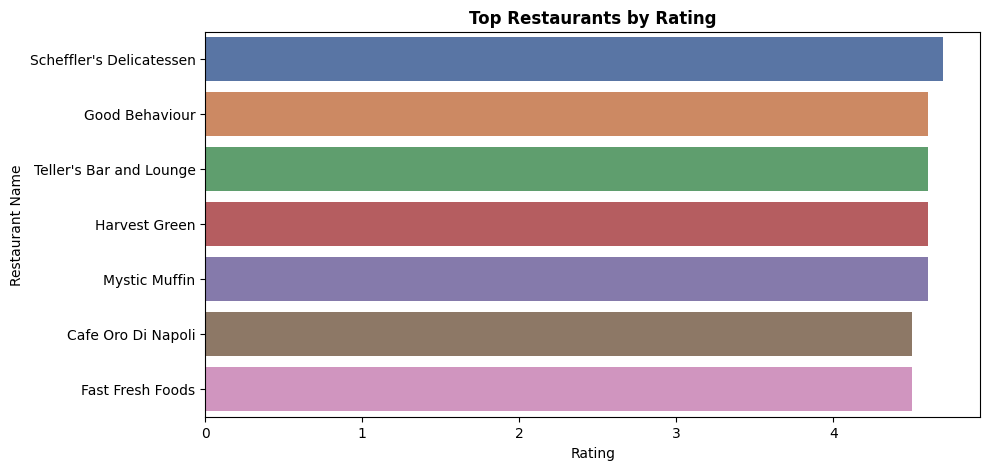

In [156]:
top_restaurants = y_restaurants_df.sort_values(by='rating', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='rating', y='name', data=top_restaurants, hue='name', palette='deep', legend=False)
plt.title('Top Restaurants by Rating', fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Restaurant Name')
plt.show()
